> Data: 06.18.2025

# Practical Lab 2 - Multivariate Linear Regression, Non-Parametric Models and Cross-Validation

## Part 1

### 1. Get the data.

In [34]:
# Import libraries
from sklearn import datasets

# Load the diabetes dataset as a pandas DataFrame
diabetes = datasets.load_diabetes(as_frame=True)

# Display the first few rows of the DataFrame
print(diabetes.frame.head())

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0  


### 2. Frame the Problem. Notice that the dependent variable of diabetes progression, namely "disease progression one year after baseline".
We need to predict disease progression one year after baseline. We use a continuous target variable, like

1. Input: X is Features (Features of diabetes/Independent Variables): include 10 standardized clinical measurement variables.

2. Output: y is Target (Target of diabetes/Dependent Variable): the diabetes disease progression score within one year after baseline.

Thus, this project is a supervised regression problem. 

Practical Application:

We use prediction models, which these models as a clinical screening tool. Help physicians identify high-risk patients and provide personalized medical advice. 

### 3. EDA - Describe the data, explore it, and provide insights about it (include statistics, scatter plots, histograms, and a correlation matrix analysis).

Statistical description:

The diabetes dataset includes 10 baseline characteristics of 442 patients and disease progression scores after one year.

(1) Number of samples: 442

(2) Number of Feature: 10

The main characteristics as follows:
| Feature Name | Illustrate |
|---|---|
| age | age in years |
| sex | sex |
| bmi | body mass index |
| bp | average blood pressure |
| s1 tc | total serum cholesterol |
| s2 ldl | low-density lipoproteins |
| s3 hdl | high-density lipoproteins |
| s4 tch | total cholesterol / HDL |
| s5 ltg | possibly log of serum triglycerides level |
| s6 glu | blood sugar level |

(3) Target variable: Disease progression score after one year. That is the Target of the diabetes dataset.

Scatter Plots:

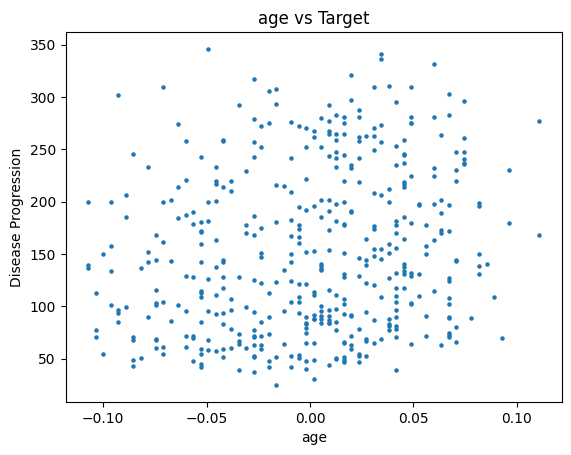

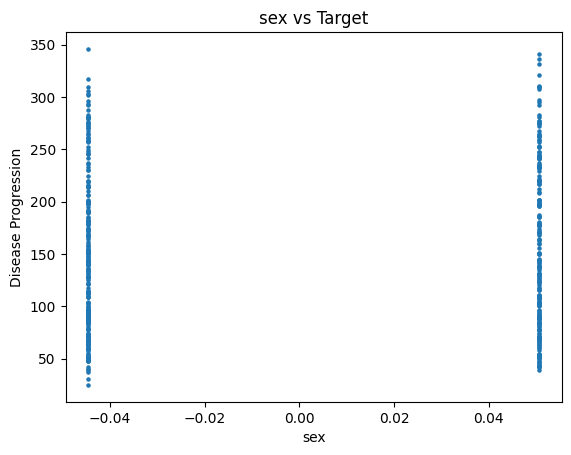

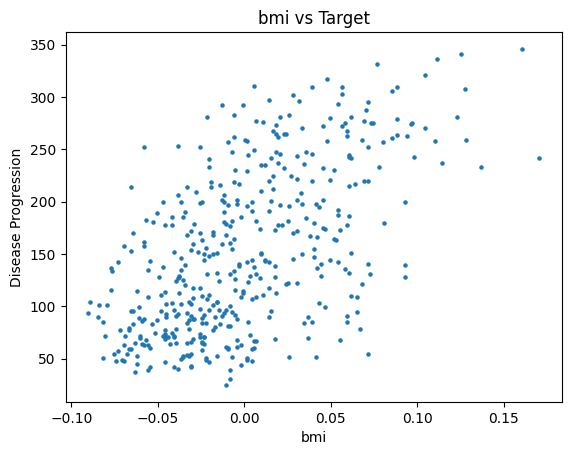

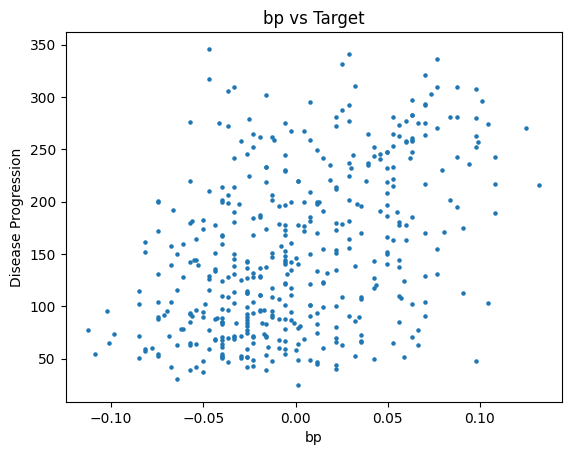

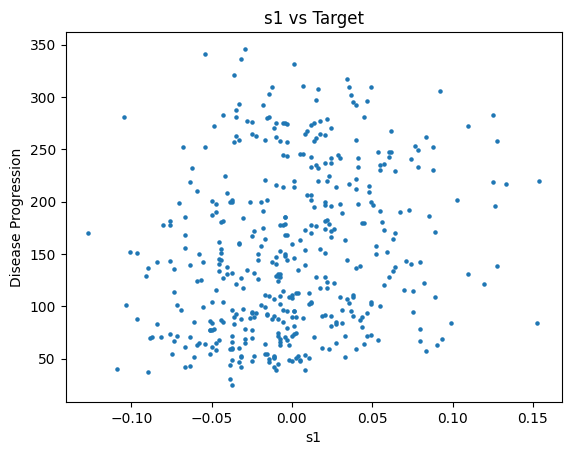

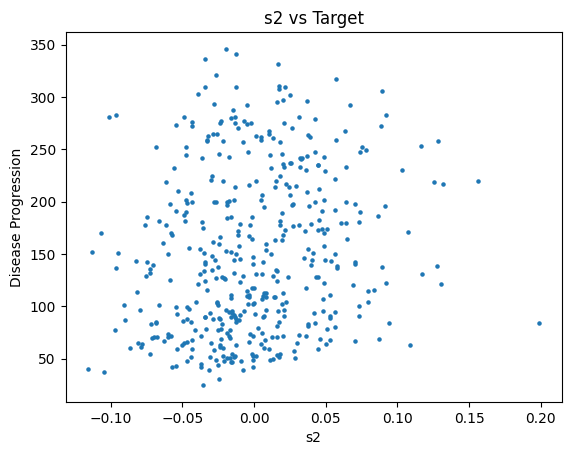

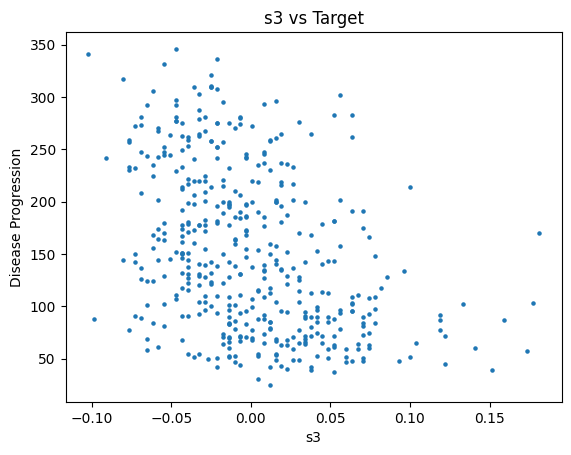

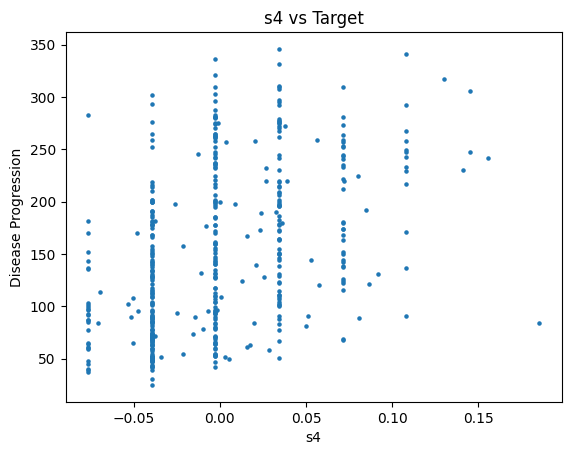

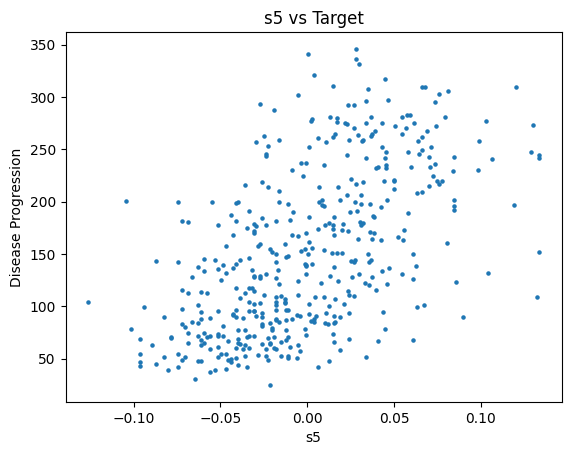

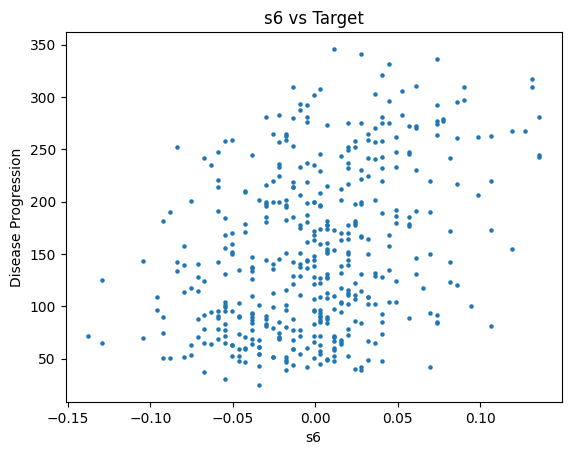

In [35]:
# import library
import matplotlib.pyplot as plt

# Display scatter plots for each feature against the target variable
for feature in diabetes['feature_names']:
    plt.scatter(diabetes['data'][feature], diabetes['target'], s=5)
    plt.xlabel(feature)
    plt.ylabel('Disease Progression')
    plt.title(f'{feature} vs Target')
    plt.show()

Conclusion:

About these Scatter Plots,  we can see only `bmi`, `pb`, and `s5` vs. `target` have a linear relationship, indicating that these features may contribute significantly to the prediction.

Histograms:

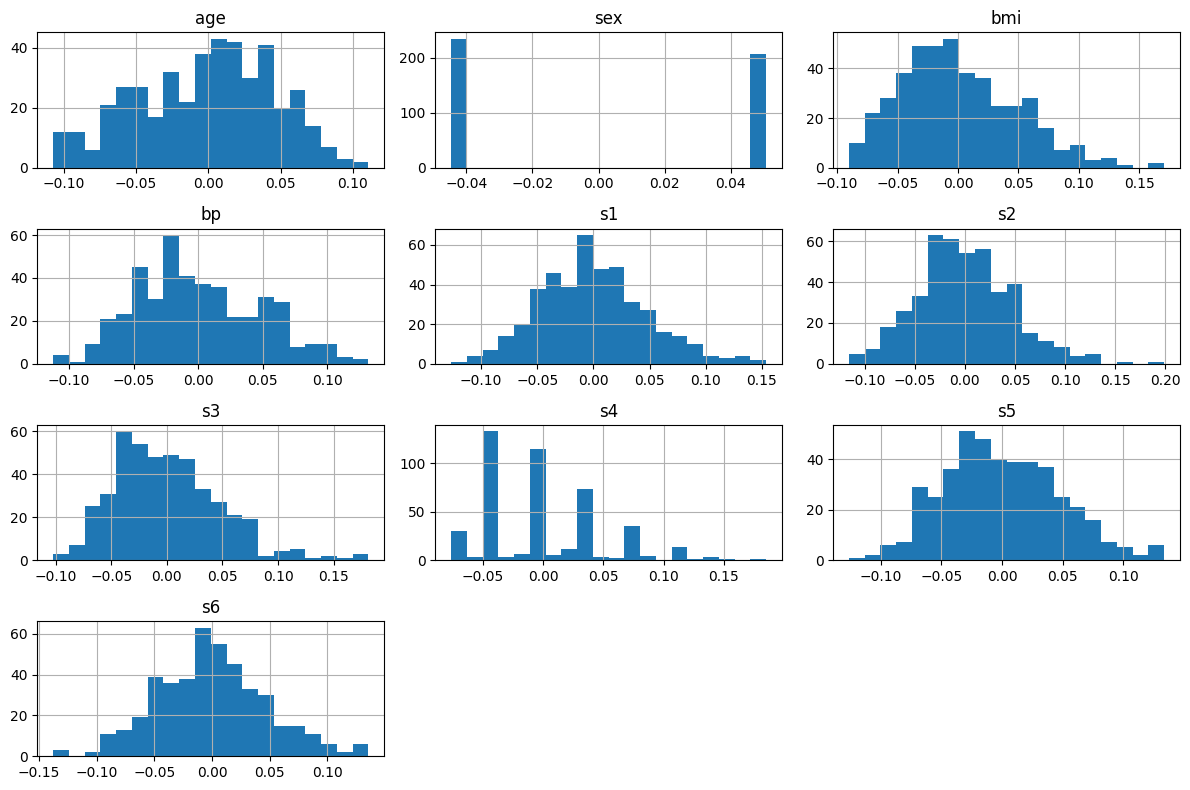

In [36]:
# Display histograms for each feature against the target variable
diabetes['data'].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

Conclusion:

Most histogram distributions are approximately normal distributions; this is a relatively ideal distribution. The `sex` and `s4` features are not suitable for histogram prediction.

Correlation Matrix(Using heatmap):

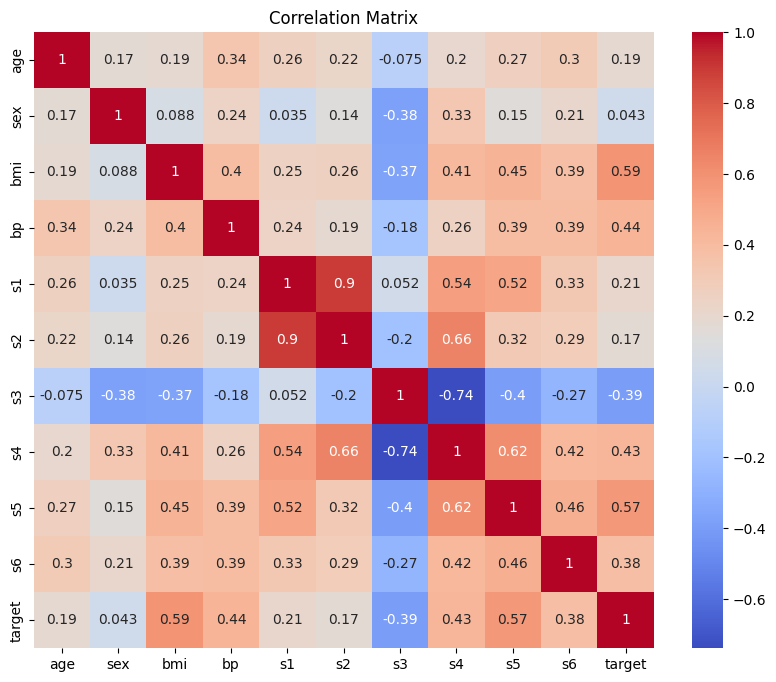

In [37]:
# Import library
import seaborn as sns

# Display heatmap for each feature against the target variable
corr = diabetes['data'].join(diabetes['target']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

(1) Correlation of the target variable: it shows the association between each feature and the target of disease progression.
- bmi (0.59), s5 (0.57), bp (0.44), s4 (0.43), s6 (0.38), s1 (0.21), age (0.19), s2 (0.17) are positively correlated with the target. The bmi and s5 have the strongest correlation, indicating a higher degree of disease progression.
- s3 (-0.39) is negatively correlated with target, indicating a lower degree of disease progression.
- sex (0.043) has a very weak correlation with target, indicating sex may not be a strong factor in predicting diabetes progression.

(2) Correlations between features:
- s1 and s2 (0.9): there is a strong positive correlation; these two serum measurements are highly linearly related.
- s3 and s4 (-0.74): there is a strong negative correlation.
- s5 and s6 (0.76): there is a strong positive correlation.

Conclusion:

- `bmi` and `s5` were the two features most positively correlated with diabetes disease progression.
- `s3` was the most negatively correlated feature. 
- `sex` had a very weak linear relationship with disease progression.

Key insights and conclusions:
- `bmi` and `s5` are the important predictive features with the disease progression score. When building models, use these two features first.
- Some features have low correlation, which can help improve model stability and interoperability.
- Most features are normally distributed, indicating that after standardization, the data quality is good. Only think about extreme values.
- No obvious missing values ​​or outliers, indicating high data integrity.

### 4. Clean the data

In [38]:
# Check for missing values
print("Check missing values of dataset:")
print(diabetes['data'].isnull().sum())
print("\n")

# Check for data types
print("Check data types for each items:")
print(diabetes['data'].dtypes)

Check missing values of dataset:
age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64


Check data types for each items:
age    float64
sex    float64
bmi    float64
bp     float64
s1     float64
s2     float64
s3     float64
s4     float64
s5     float64
s6     float64
dtype: object


Conclusion:

According to Scikit-Learn's Diabetes dataset is a small, organized dataset. These features have been mean-centered and standardized. Also, checked the missing values and data type. We didn't clean the data.

### 5. Split the dataset to a train (75%), validation set (10%), and test set (15%).

Divide the data set into three parts:
- Training set: 75%
- Validation set: 10%
- Test set: 15%

Using train_test_split to divide:

(1) dataset split 75% training set and 25% temporary set

(2) 25% temporary set split 10% validation set and 15% test set

In [39]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split the training set (75%) and the temporary set (25%)
X_train, X_temp, y_train, y_temp = train_test_split(diabetes['data'], diabetes['target'], test_size=0.25, random_state=42)

# Split the temporary set into the validation set (10%) and the test set (15%)
# Validation set ratio = 10% / 25% = 0.4
# Test set ratio = 15% / 25% = 0.6
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

## Part 2

### 6. Models: a univariate polynomial regression on the BMI feature versus the "disease progression one year after baseline" - from degree 0 to 5 (6 models).

In [40]:
# Import functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Get BMI features and set parameters
X_train_bmi = X_train[['bmi']]
X_val_bmi = X_val[['bmi']]
X_test_bmi = X_test[['bmi']]

# Initializes an empty list
models = []
poly_features = []

# Create linear regression for polynomial features of degree 0 to 5
for degree in range(6):
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    X_train_poly = poly.fit_transform(X_train_bmi)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    models.append(model)
    poly_features.append(poly)

### 7. Compare the models using the training and validation data and calculate R-Squared, Mean Absolute Error (MAE), and MAPE. Construct a table summarizing the train validation results.

In [41]:
# Import library and functions
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

# Define calculate_mape function
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Initializes an empty list
results = []

for degree in range(6):
    # Prediction of the training set
    X_train_poly = poly_features[degree].transform(X_train_bmi)
    y_train_pred = models[degree].predict(X_train_poly)
    # Prediction of the validation set
    X_val_poly = poly_features[degree].transform(X_val_bmi)
    y_val_pred = models[degree].predict(X_val_poly)

    # Calculate indicators for the training set
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mape = calculate_mape(y_train, y_train_pred)

    # Calculate indicators for the validation set
    val_r2 = r2_score(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mape = calculate_mape(y_val, y_val_pred)

    results.append([degree, train_r2, train_mae, train_mape, val_r2, val_mae, val_mape])
    
# Display results in a table
columns = [
    'Degree', 'Train R2', 'Train MAE', 'Train MAPE',
    'Val R2', 'Val MAE', 'Val MAPE'
]

results_df = pd.DataFrame(results, columns=columns)
print("Calculate R-Squared, MAE, and MAPE table:")
results_df

Calculate R-Squared, MAE, and MAPE table:


,Degree,Train R2,Train MAE,Train MAPE,Val R2,Val MAE,Val MAPE
0,0,0.000000,66.201641,62.826669,-0.106957,66.057059,71.263880
1,1,0.349672,52.287739,48.362886,0.331264,47.208472,47.060009
2,2,0.350764,52.207314,48.298534,0.331631,47.213700,47.239667
3,3,0.350774,52.198968,48.280744,0.331638,47.185414,47.222673
4,4,0.353014,52.092653,48.053266,0.340758,46.090118,46.050330
5,5,0.354100,52.059191,48.004022,0.349881,45.462121,45.175275


### 8. Identify the best model based on the table above.

Evaluation indicators:
- R-Squared (R²): the closer to 1, the model has stronger explanatory power.
- MAE (mean absolute error): the lower the better, indicating that the average difference between the predicted value and the true value is small.
- MAPE (mean absolute percentage error): The lower the better, indicating that the proportion of the predicted error to the true value is smaller.

From the table of results_df, 
- Degree=0 (constant model): the lowest R² and highest MAE and MAPE in the validation set, it has the worst predictive ability.
- Degree=1~3: R² is around 0.33, and MAE and MAPE are also relatively low in the validation set.
- Degree=4~5: in the validation set, R² has not improved significantly, or even slightly decreased, and MAE/MAPE has not improved, indicating that the high-order model does not bring better generalization and may be overfitting.

Conclusion:

According to the table of results_df, conforming to the R²/MAE/MAPE evaluation indicators judgment, the best model is a polynomial regression model with degree=1 or degree=2. We can choose the R²/MAE/MAPE of the validation set. Also, it can model predictive ability and model simplicity, and avoid overfitting.

### 9. Run the chosen model on the test set and provide results (R-Squared, MAPE, MAE)
Here we assume the best model is degree=2.

In [42]:
# Assume the best model is degree=2
best_degree = 2
best_model = models[best_degree]
best_poly = poly_features[best_degree]

# Transform test set features
X_test_poly = best_poly.transform(X_test_bmi)

# Predict test set
y_test_pred = best_model.predict(X_test_poly)

# Calculate indicators
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = calculate_mape(y_test, y_test_pred)

# Display test set results
print("Test set results:")
print("Test R2:", test_r2)
print("Test MAE:", test_mae)
print("Test MAPE:", test_mape)

Test set results:
Test R2: 0.27229350251056683
Test MAE: 51.7901764908394
Test MAPE: 43.39312271538569


From the Test set result:
- R² approximately 0.27, indicating about 27% of the variation in disease progression. This result is close to the validation set.
- MAE approximately 51.79, indicating the mean absolute error between the predicted value and the true value is about 51.79 points.
- MAPE approximately 43.39, indicating the average prediction error accounts for about 43.39% of the true value.

Conclusion:

The performance of the best model on the test set is propinquity to that on the validation set, indicating that its generalization ability is stable and may be can used for actual clinical prediction.

### 10. Plot a graph of the train, validation and test data points, and the fit of the chosen model over each of them
We still assume the best model is degree=2.

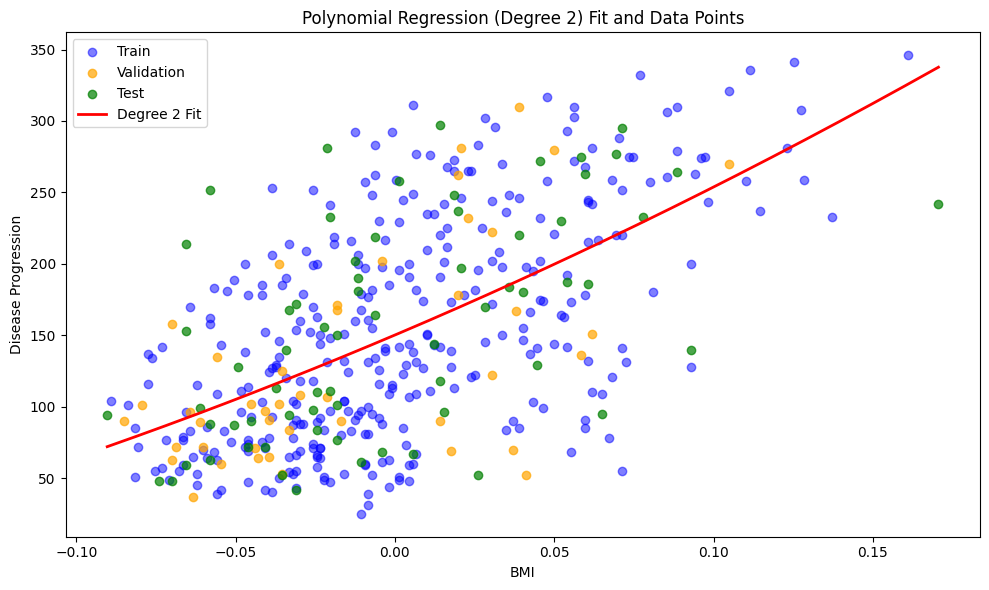

In [43]:
# Create BMI range
bmi_min = np.min(np.vstack([X_train_bmi, X_val_bmi, X_test_bmi]))
bmi_max = np.max(np.vstack([X_train_bmi, X_val_bmi, X_test_bmi]))
bmi_range = np.linspace(bmi_min, bmi_max, 200).reshape(-1, 1)

# Here X_train_bmi is a DataFrame, get its column names
bmi_col = X_train_bmi.columns[0]
bmi_range_df = pd.DataFrame(bmi_range, columns=[bmi_col])

# prediction curve
bmi_range_poly = best_poly.transform(bmi_range_df)
y_pred_curve = best_model.predict(bmi_range_poly)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_bmi, y_train, color='blue', alpha=0.5, label='Train')
plt.scatter(X_val_bmi, y_val, color='orange', alpha=0.7, label='Validation')
plt.scatter(X_test_bmi, y_test, color='green', alpha=0.7, label='Test')
plt.plot(bmi_range, y_pred_curve, color='red', linewidth=2, label='Degree 2 Fit')
plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.title('Polynomial Regression (Degree 2) Fit and Data Points')
plt.legend()
plt.tight_layout()
plt.show()

Conclusion:
- The polynomial regression model of Degree 2 (red line) displays a positive correlation between BMI and diabetes progression after one year.
- The red curve is smooth, indicating the dataset is not overfit. The degree 2 model can balance the explanatory power and generalization ability.
-  The degree 2 model is a robust basic model.

### 11. Write down the equation of the best model (with a two decimal digit precision, assuming it's sufficient)

In [44]:
# Get coefficients and term names
coefs = np.round(best_model.coef_, 2)
intercept = np.round(best_model.intercept_, 2)
terms = best_poly.get_feature_names_out(['bmi'])

# Combine equations
equation = f"y = {intercept}"
for coef, term in zip(coefs[1:], terms[1:]): # Skip the first term (usually the intercept)
    sign = '+' if coef >= 0 else '-'
    equation += f" {sign} {abs(coef)}*{term}"

print("Model equation:")
print(equation)

Model equation:
y = 150.15 + 946.69*bmi + 894.88*bmi^2


### 12. Calculate the expected diabetes progression for a BMI value of your choice using `model.perdict()` for that value
We set the bmi value for 0.05, which is the middle right of bmi range, indicating reasonable BMI normalization values.

In [45]:
# The best model has degree=2 and the column name is 'bmi'
bmi_value = 0.05 # Fill in the (standardized) BMI value you want to predict here
bmi_df = pd.DataFrame([[bmi_value]], columns=['bmi'])

# Polynomial feature transformation
bmi_poly = best_poly.transform(bmi_df)

# Predict disease progression
predicted_progression = best_model.predict(bmi_poly)
print(f"Expected disease progression score: {predicted_progression[0]:.2f}")

Expected disease progression score: 199.72


Conclusion:

For patients with a standardized BMI value of 0.05, the model predicts that their diabetes progression score after one year will be approximately 199.72 points. If the score is higher, the more severe the expected disease progression.

### 13. How many trainable parameters are we fitting for each of the models (using use sklearn function `get_feature_names_out()`)? 

In [46]:
for degree in range(6):
    feature_names = poly_features[degree].get_feature_names_out(['bmi'])
    num_params = len(feature_names) # One parameter for each feature
    print(f"Degree {degree}: {num_params} trainable parameters -> {feature_names}")

Degree 0: 1 trainable parameters -> ['1']
Degree 1: 2 trainable parameters -> ['1' 'bmi']
Degree 2: 3 trainable parameters -> ['1' 'bmi' 'bmi^2']
Degree 3: 4 trainable parameters -> ['1' 'bmi' 'bmi^2' 'bmi^3']
Degree 4: 5 trainable parameters -> ['1' 'bmi' 'bmi^2' 'bmi^3' 'bmi^4']
Degree 5: 6 trainable parameters -> ['1' 'bmi' 'bmi^2' 'bmi^3' 'bmi^4' 'bmi^5']


Conclusion:

- Each parameter corresponds to a polynomial term that includes intercept, bmi, bmi^2, bmi^3, etc.
- These parameters are learned by model training to minimize the error between the predicted value and the true value.
- If more parameters are used, the model becomes more complex and flexible, but it is also more prone to overfitting.

### 14. Conclusion
Summary:

This project uses a univariate BMI polynomial regression model (degree 0~5) to predict the disease progression score of diabetic patients one year later. The best model is degree=2; the model displays a positive nonlinear relationship between BMI and diabetes progression (after one year). Also, the training, validation, and test sets are stable. We calculate R², MAE, and MAPE within a reasonable range. That indicates the degree 2 model has predictive ability.

Model limitations:

- This model only uses the BMI feature, does not consider other features. The predictive capabilities are not comprehensive enough.
- The data distribution assumption does not the prediction effect for out-of-distribution data is unknown
- Existence of large prediction error. This model only displays the overall trend, but the prediction error increases significantly with some data points. Indicating this model has limited generalization ability
- Polynomial models are extremely sensitive to outliers, especially at high orders, which can easily lead to local poor fit or global curve anomalies.

Suggestions:

If the basic risk prediction tool is used, we can use this model. In actual application, we need to combine with more clinical characteristics and advanced models. Achieving an effective and accurate model and risk prediction tool.

Conclusion:

This project proves that univariate polynomial regression can be used as an entry-level method for predicting diabetes progression, but the model's predictive power and robustness are limited. We need to use multiple features and multiple complex models to predict. This can meet the actual clinical needs.

## Part 3
### We use all the features in the dataset. Repeat the steps in part 2 for the following models:
### 1. Two polynomial models (here use degrees=2 and 3)

In [47]:
# Initializes an empty list
results_polynomial = []

# Step 1: Use `PolynomialFeatures` to generate polynomial features
# Create polynomial features of degree 2 for the training, validation, and test sets
poly2 = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly2 = poly2.fit_transform(X_train)
X_val_poly2 = poly2.transform(X_val)
X_test_poly2 = poly2.transform(X_test)

# Create polynomial features of degree 3 for the training, validation, and test sets
poly3 = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly3 = poly3.fit_transform(X_train)
X_val_poly3 = poly3.transform(X_val)
X_test_poly3 = poly3.transform(X_test)


# Step 2: Training a Polynomial Regression Model
# Create and fit a linear regression model using the polynomial features of degree 2
model_poly2 = LinearRegression()
model_poly2.fit(X_train_poly2, y_train)

# Create and fit a linear regression model using the polynomial features of degree 3
model_poly3 = LinearRegression()
model_poly3.fit(X_train_poly3, y_train)


# Step 3: Prediction and evaluation
# Evaluate the model on the training, validation, and test sets using R2, MAE, and MAPE for degree 2
for X_poly, y, label in [
    (X_train_poly2, y_train, "Train"),
    (X_val_poly2, y_val, "Validation"),
    (X_test_poly2, y_test, "Test")
]:
    y_pred = model_poly2.predict(X_poly)
    r2 = round(r2_score(y, y_pred), 3)
    mae = round(mean_absolute_error(y, y_pred), 2)
    mape = round(calculate_mape(y, y_pred), 2)
    results_polynomial.append(['Poly2', label, r2, mae, mape])

# Evaluate the model on the training, validation, and test sets using R2, MAE, and MAPE for degree 3
for X_poly, y, label in [
    (X_train_poly3, y_train, "Train"),
    (X_val_poly3, y_val, "Validation"),
    (X_test_poly3, y_test, "Test")
]:
    y_pred = model_poly3.predict(X_poly)
    r2 = round(r2_score(y, y_pred), 3)
    mae = round(mean_absolute_error(y, y_pred), 2)
    mape = round(calculate_mape(y, y_pred), 2)
    results_polynomial.append(['Poly3', label, r2, mae, mape])


# Step 4: Display results tables
# Convert to DataFrame
columns = ['Model', 'Dataset', 'R2', 'MAE', 'MAPE(%)']

# Display results in a DataFrame
df_results_polynomial = pd.DataFrame(results_polynomial, columns=columns)
print("Polynomial regression results:")
print(df_results_polynomial)
print("\n")

# Convert to wide format
df_pivot = df_results_polynomial.pivot(index='Model', columns='Dataset', values=['R2', 'MAE', 'MAPE(%)'])
print("Polynomial regression results in wide format:")
df_pivot

Polynomial regression results:
   Model     Dataset      R2     MAE  MAPE(%)
0  Poly2       Train   0.605   39.22    34.61
1  Poly2  Validation   0.426   41.80    42.28
2  Poly2        Test   0.399   45.49    37.95
3  Poly3       Train   0.910   15.65    14.36
4  Poly3  Validation -43.280  241.22   231.21
5  Poly3        Test -65.832  243.16   213.85


Polynomial regression results in wide format:


R2                       MAE                   MAPE(%)         \
Dataset    Test  Train Validation    Test  Train Validation    Test  Train   
Model                                                                        
Poly2     0.399  0.605      0.426   45.49  39.22      41.80   37.95  34.61   
Poly3   -65.832  0.910    -43.280  243.16  15.65     241.22  213.85  14.36   

                    
Dataset Validation  
Model               
Poly2        42.28  
Poly3       231.21

Compare the univariate polynomial regression results of Patr 2:
- On all data sets, R² was significantly improved, and MAE and MAPE also decreased slightly. The multivariate Poly2 (degree=2) model is significantly better than the univariate model, indicating that the model adds multiple clinical features, and it can better explain the variation in disease progression.
- The Poly3 (degree=3) results, the training set R², MAE, and MAPE are very well, but in the validation and test sets, the R² is negative, and MAE and MAPE are very large. This model loses generalization ability and displays overfitting.

Conclusion of multivariate polynomial regression:
- Multivariate polynomial regression (degree=2) is better than a single BMI feature model.
- Multivariate polynomial regression (degree=3) will cause serious overfitting and reduce the generalization effect.  Avoid using polynomials of too high an order.
- Suggest performance and robustness when selecting a model, and attention to the actual effect of the model on the validation and test sets.

### 2. Two decision trees (e.g. consider changing the `max_depth` hyperparameter)

In [48]:
# Import functions
from sklearn.tree import DecisionTreeRegressor

# Step 1: Train two decision tree models
# max_depth=3
tree3 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree3.fit(X_train, y_train)

# max_depth=5
tree5 = DecisionTreeRegressor(max_depth=5, random_state=42)
tree5.fit(X_train, y_train)


# Step 2: Prediction and evaluation
# Initializes an empty list
results_decision_tree = []

for model, name in [(tree3, "Tree_d3"), (tree5, "Tree_d5")]:
    for X, y, label in [
        (X_train, y_train, "Train"),
        (X_val, y_val, "Validation"),
        (X_test, y_test, "Test")
    ]:
        y_pred = model.predict(X)
        r2 = round(r2_score(y, y_pred), 3)
        mae = round(mean_absolute_error(y, y_pred), 2)
        mape = round(calculate_mape(y, y_pred), 2)
        results_decision_tree.append([name, label, r2, mae, mape])


# Step 3: Display results tables
df_results_decision_tree = pd.DataFrame(results_decision_tree, columns=['Model', 'Dataset', 'R2', 'MAE', 'MAPE(%)'])
print("Decision tree regression results:")
print(df_results_decision_tree)
print("\n")

# Convert to wide format
df_pivot_decision_tree = df_results_decision_tree.pivot(index='Model', columns='Dataset', values=['R2', 'MAE', 'MAPE(%)'])
print("Decision tree regression resultss in wide format:")
df_pivot_decision_tree

Decision tree regression results:
     Model     Dataset     R2    MAE  MAPE(%)
0  Tree_d3       Train  0.510  44.26    38.87
1  Tree_d3  Validation  0.198  48.13    47.67
2  Tree_d3        Test  0.438  46.12    40.18
3  Tree_d5       Train  0.687  33.53    29.97
4  Tree_d5  Validation  0.094  49.65    48.16
5  Tree_d5        Test  0.366  47.74    39.53


Decision tree regression resultss in wide format:


R2                      MAE                   MAPE(%)         \
Dataset   Test  Train Validation   Test  Train Validation    Test  Train   
Model                                                                      
Tree_d3  0.438  0.510      0.198  46.12  44.26      48.13   40.18  38.87   
Tree_d5  0.366  0.687      0.094  47.74  33.53      49.65   39.53  29.97   

                    
Dataset Validation  
Model               
Tree_d3      47.67  
Tree_d5      48.16

Conclusion of decision tree regression:

From the decision tree regression results,
- Tree_d3 can capture nonlinear relationships in some data, but validation and test sets are significantly reduced. indicating the model has limited overall predictive power and generalization ability.
- Tree_d5 will improve the training set performance, but validation and test sets MAE and MAPE increased significantly, indicating that the model began to overfit.

### 3. Two kNNs

In [49]:
# Import functions
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# Step 1: Using `StandardScaler` to do data standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# Step 2: Build and train two kNN regression models
# k=3
knn3 = KNeighborsRegressor(n_neighbors=3)
knn3.fit(X_train_scaled, y_train)

# k=7
knn7 = KNeighborsRegressor(n_neighbors=7)
knn7.fit(X_train_scaled, y_train)


# Step 3: Prediction and evaluation
# Initializes an empty list
results_knn = []

for model, name in [(knn3, "kNN_3"), (knn7, "kNN_7")]:
    for X, y, label in [
        (X_train_scaled, y_train, "Train"),
        (X_val_scaled, y_val, "Validation"),
        (X_test_scaled, y_test, "Test")
    ]:
        y_pred = model.predict(X)
        r2 = round(r2_score(y, y_pred), 3)
        mae = round(mean_absolute_error(y, y_pred), 2)
        mape = round(calculate_mape(y, y_pred), 2)
        results_knn.append([name, label, r2, mae, mape])

# Step 4: Display results tables
df_results_knn = pd.DataFrame(results_knn, columns=['Model', 'Dataset', 'R2', 'MAE', 'MAPE(%)'])
print("KNN regression results:")
print(df_results_knn)
print("\n")

# Convert to wide format
df_pivot_knn = df_results_knn.pivot(index='Model', columns='Dataset', values=['R2', 'MAE', 'MAPE(%)'])
print("KNN regression results in wide format:")
df_pivot_knn

KNN regression results:
   Model     Dataset     R2    MAE  MAPE(%)
0  kNN_3       Train  0.624  37.12    31.55
1  kNN_3  Validation  0.281  43.20    41.41
2  kNN_3        Test  0.417  44.84    36.59
3  kNN_7       Train  0.524  43.18    37.30
4  kNN_7  Validation  0.389  40.75    38.34
5  kNN_7        Test  0.479  41.48    35.16


KNN regression results in wide format:


R2                      MAE                   MAPE(%)         \
Dataset   Test  Train Validation   Test  Train Validation    Test  Train   
Model                                                                      
kNN_3    0.417  0.624      0.281  44.84  37.12      43.20   36.59  31.55   
kNN_7    0.479  0.524      0.389  41.48  43.18      40.75   35.16  37.30   

                    
Dataset Validation  
Model               
kNN_3        41.41  
kNN_7        38.34

Conclusion of kNNs:

- Model with k=3(k value is smaller) performs better in the R² of the training set, indicating that the model fits well. In the validation and test sets, R² will decrease, indicating that the model's generalization ability is limited. Also, MAE and MAPE are high, and the prediction error is still large.
- Model with k=7(k value is larger) has a stronger model generalization ability. Also, more stable performance in the validation and test sets, and lower error, making it a better choice.
- kNNs have predictive ability for nonlinear relationships, but when the R² is about 0.3~0.5, the prediction accuracy is limited.


### Model Performance Summary and Conclusions
In the test set R², the first three performance rankings:
1. kNN_7 (0.479)
2. Tree_d3 (0.438)
3. Poly2 (0.399)


The Best models:
- kNN_7 (k=7) performs best on the test set (R²=0.479), indicating the strongest generalization ability and relatively stable prediction error (MAE=41.48, MAPE=35.16%).
- Poly2 (polynomial regression, degree=2) performs second best (R²=0.399), balancing fitting and generalization, but its prediction accuracy is slightly lower than kNN_7.


The models have an overfitting problem:
- Poly3 (degree=3) has R²=-65.8 on the training set, it is severely overfitted and loses its predictive ability, indicating that high-order polynomials are not suitable for this task.
- Tree_d5 (decision tree, max_depth=5) has R²=0.687 on the training set, but R²=0.366 on the test set, indicating that increasing the tree depth leads to overfitting.


Conclusion of model:

In this project, kNN_7 and Poly2 are the best and robust models. Avoid decision trees and high-order polynomial models, because they will lead to overfitting. 